In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyodbc
import pmdarima

In [2]:
db = 'AdventureWorks2012'
server = 'DESKTOP-RDRRI0S'

#create the connection
conn = pyodbc.connect('DRIVER={SQL SERVER};SERVER=' + server + ';DATABASE=' + db + ';Trusted_Connection=yes')



#query 
query = """
SELECT SOH.OrderDate AS OrderDate,
       (SOD.UnitPrice * SOD.OrderQty) AS Revenue, 
	   SOH.OnlineOrderFlag,
	   CASE WHEN
	    SOH.OnlineOrderFlag = 1 THEN 'Online'
		ELSE 'Reseller'
		END AS SalesChannel,
		ST.Name AS Region
FROM [Sales].[SalesOrderDetail] AS SOD
LEFT JOIN [Sales].[SalesOrderHeader] AS SOH
ON SOD.[SalesOrderID] = SOH.[SalesOrderID]
LEFT JOIN [Production].[Product] AS PP
ON SOD.ProductID = PP.ProductID
LEFT JOIN [Sales].[SalesTerritory] AS ST
ON SOH.TerritoryID = ST.TerritoryID

"""

In [3]:
#reading the sql file from the engine and set OrderDate column as index
df = pd.read_sql(query, conn, index_col = 'OrderDate', parse_dates=True) 

print(df)

             Revenue  OnlineOrderFlag SalesChannel     Region
OrderDate                                                    
2011-05-31  2024.994            False     Reseller  Southeast
2011-05-31  6074.982            False     Reseller  Southeast
2011-05-31  2024.994            False     Reseller  Southeast
2011-05-31  2039.994            False     Reseller  Southeast
2011-05-31  2039.994            False     Reseller  Southeast
...              ...              ...          ...        ...
2014-06-30    21.980             True       Online     Canada
2014-06-30     8.990             True       Online     Canada
2014-06-30    21.980             True       Online     Canada
2014-06-30   159.000             True       Online     Canada
2014-06-30     8.990             True       Online     Canada

[121317 rows x 4 columns]


In [4]:
#Delete the OnlineoRderFlag Column
df = df.drop(['OnlineOrderFlag'], axis=1)

In [5]:
type(df)

pandas.core.frame.DataFrame

In [6]:
df.head()

,Revenue,SalesChannel,Region
OrderDate,,,
2011-05-31,2024.994,Reseller,Southeast
2011-05-31,6074.982,Reseller,Southeast
2011-05-31,2024.994,Reseller,Southeast
2011-05-31,2039.994,Reseller,Southeast
2011-05-31,2039.994,Reseller,Southeast


In [7]:
df.tail()

,Revenue,SalesChannel,Region
OrderDate,,,
2014-06-30,21.98,Online,Canada
2014-06-30,8.99,Online,Canada
2014-06-30,21.98,Online,Canada
2014-06-30,159.00,Online,Canada
2014-06-30,8.99,Online,Canada


In [8]:
#Select Revenue column
df0 = df[['Revenue']]    
df0

,Revenue
OrderDate,
2011-05-31,2024.994
2011-05-31,6074.982
2011-05-31,2024.994
2011-05-31,2039.994
2011-05-31,2039.994
...,...
2014-06-30,21.980
2014-06-30,8.990
2014-06-30,21.980


In [9]:
type(df0)

pandas.core.frame.DataFrame

In [10]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121317 entries, 2011-05-31 to 2014-06-30
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Revenue  121317 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [11]:
#Grouping the data by monthly revenue and finding the mean for each month
df0 = df0.resample('MS').mean()

df0

,Revenue
OrderDate,
2011-05-01,1411.221056
2011-06-01,3254.686701
2011-07-01,2174.564385
2011-08-01,2009.955727
2011-09-01,3197.922585
2011-10-01,2203.972573
2011-11-01,3207.999223
2011-12-01,2318.542982
2012-01-01,2319.296981


### Visualizing the Data

In [12]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 5

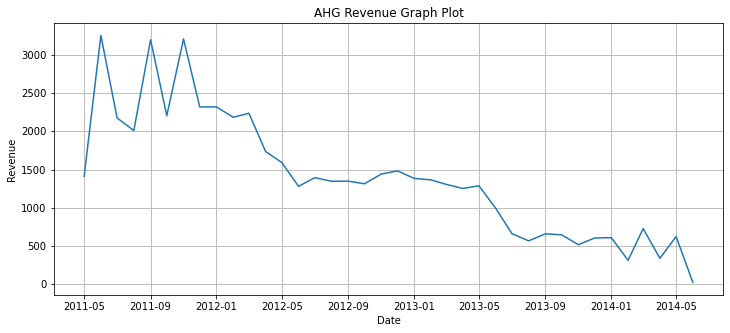

In [13]:
#plot date to see what it looks like
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.title ('AHG Revenue Graph Plot')
plt.plot(df0)

In [14]:
#Testing for Stationarity using Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ad_test(df0):
    dftest = adfuller(df0, autolag = 'AIC')
    print('1. ADF: ', dftest[0])
    print('2. P-Values: ', dftest[1])
    print('3. Num of Lags: ', dftest[2])
    print('4. Num of Observations Used for ADF Regression and Critical Values Calculation: ', dftest[3])
    print('5. Critical Values :')
    for key, value in dftest[4].items():
        print('\t',key, ': ', value)

In [15]:
ad_test(df0['Revenue'])

1. ADF:  -1.219925456661225
2. P-Values:  0.6649660926199957
3. Num of Lags:  10
4. Num of Observations Used for ADF Regression and Critical Values Calculation:  27
5. Critical Values :
	 1% :  -3.6996079738860943
	 5% :  -2.9764303469999494
	 10% :  -2.627601001371742


### Differencing

#### Seeing that the data is not stationary, we would need to do differencing to make it stationary

In [16]:
df0['Revenue First Difference'] = df0['Revenue'] - df0['Revenue'].shift(1)

In [17]:
df0

,Revenue,Revenue First Difference
OrderDate,,
2011-05-01,1411.221056,NaN
2011-06-01,3254.686701,1843.465645
2011-07-01,2174.564385,-1080.122316
2011-08-01,2009.955727,-164.608658
2011-09-01,3197.922585,1187.966858
2011-10-01,2203.972573,-993.950012
2011-11-01,3207.999223,1004.026651
2011-12-01,2318.542982,-889.456242
2012-01-01,2319.296981,0.753999


In [18]:
#Re-do the Dickey-Fuller Test using the Revenue First Difference
ad_test(df0['Revenue First Difference'].dropna())

1. ADF:  -8.137194596884774
2. P-Values:  1.0514565293593972e-12
3. Num of Lags:  1
4. Num of Observations Used for ADF Regression and Critical Values Calculation:  35
5. Critical Values :
	 1% :  -3.6327426647230316
	 5% :  -2.9485102040816327
	 10% :  -2.6130173469387756


<AxesSubplot:title={'center':'AHG Differencing Revenue Graph Plot'}, xlabel='OrderDate'>

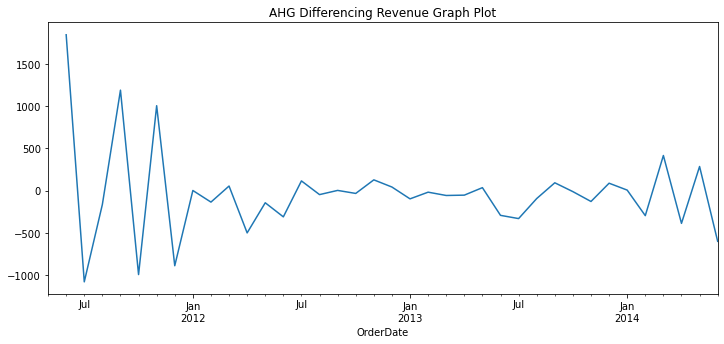

In [19]:
#Do the plot for the Revenue First Difference
plt.title ('AHG Differencing Revenue Graph Plot')
df0['Revenue First Difference'].plot()

### Figure Out Order for ARIMA Model

In [20]:
from pmdarima import auto_arima

In [21]:
stepwise_fit = auto_arima(df0['Revenue'], trace=True,
                          suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=572.755, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=557.553, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=570.943, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=553.436, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=552.013, Time=0.28 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=553.816, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=553.782, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=552.415, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=556.271, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=552.239, Time=0.08 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 2.969 seconds


In [22]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(3, 1, 0)   Log Likelihood                -271.007
Date:                Wed, 03 Feb 2021   AIC                            552.013
Time:                        11:14:53   BIC                            560.068
Sample:                             0   HQIC                           554.853
                                 - 38                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -91.7590     63.558     -1.444      0.149    -216.330      32.812
ar.L1         -0.9194      0.140     -6.572      0.000      -1.194      -0.645
ar.L2         -0.1462      0.204     -0.718      0.473      -0.545       0.253
ar.L3          0.3590      0.148      2.432      0.015       0.070       0.648
sigma2      1.081e+05   2.52e+04      4.290      0.000    5.87e+04    1.57e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.90   Jarque-Bera (JB):                11.36
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                             0.85
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Training the Model

#### Splitting Data into Training and Testing

In [23]:
from statsmodels.tsa.arima_model import ARIMA

In [24]:
#Specifying and reserving the last 10 data as the test data
print (df0.shape)
train = df0.iloc[:-10]
test = df0.iloc[-10:]
print(train.shape, test.shape)

(38, 2)
(28, 2) (10, 2)


In [25]:
model = ARIMA(train['Revenue'], order=(3,1,0))
model=model.fit()
model.summary()

C:\Users\MMT\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Revenue   No. Observations:                   27
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -197.896
Method:                       css-mle   S.D. of innovations            352.261
Date:                Wed, 03 Feb 2021   AIC                            405.792
Time:                        11:15:02   BIC                            412.271
Sample:                    06-01-2011   HQIC                           407.719
                         - 08-01-2013                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -71.9243     45.019     -1.598      0.110    -160.160      16.311
ar.L1.D.Revenue    -0.9370      0.185     -5.078      0.000      -1.299      -0.575
ar.L2.D.Revenue    -0.0312      0.274     -0.114      0.909      -0.568       0.506
ar.L3.D.Revenue     0.4670      0.195      2.392      0.017       0.084       0.850
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8757           -0.6410j            1.0853           -0.3994
AR.2           -0.8757           +0.6410j            1.0853            0.3994
AR.3            1.8182           -0.0000j            1.8182           -0.0000
-----------------------------------------------------------------------------
"""

#### Make Predictions on Test Set

In [26]:
start = len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels')
print(pred)

2013-09-01    420.986664
2013-10-01    297.878148
2013-11-01    265.625461
2013-12-01    123.545602
2014-01-01     92.220214
2014-02-01      2.966722
2014-03-01    -86.745918
2014-04-01   -122.503632
2014-05-01   -235.854232
2014-06-01   -278.395583
Freq: MS, dtype: float64


<AxesSubplot:xlabel='OrderDate'>

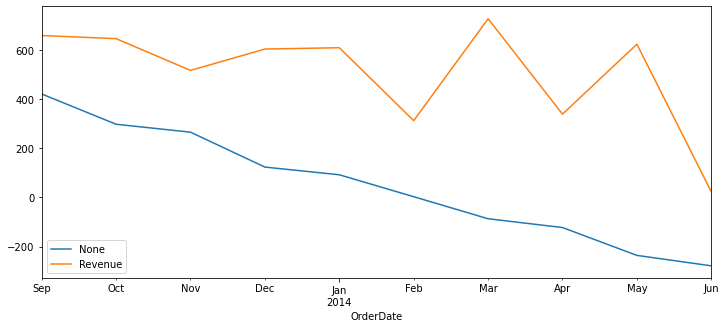

In [27]:
pred.plot(legend=True)
test['Revenue'].plot(legend=True)

In [28]:
test['Revenue'].mean()

506.05685157124924

In [29]:
#To determine how good or bad the model is, use root mean squared
#The code below gives the root mean square
#Comapre with the mean above
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['Revenue']))
print(rmse)

503.98564325658884


In [ ]:
#The root mean squared error above when compared to the mean indicates that our model isn't a good one

In [30]:
model2=ARIMA(df0['Revenue'],order=(3,1,0))
model2=model2.fit()
df0.tail()

C:\Users\MMT\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


,Revenue,Revenue First Difference
OrderDate,,
2014-02-01,312.479569,-296.798561
2014-03-01,727.166861,414.687292
2014-04-01,338.961509,-388.205352
2014-05-01,623.651075,284.689566
2014-06-01,23.007437,-600.643638


### Making predictions(forecast) for future dates - 5 years

In [31]:
#Forecasting for the next 60 days (5 years)
pred=model2.predict(start=len(df0), end=len(df0)+60,typ='levels').rename('Forecast')
print(pred)

2014-07-01     335.144676
2014-08-01     102.574288
2014-09-01     -39.345855
2014-10-01     151.814592
2014-11-01    -216.106177
                 ...     
2019-03-01   -3113.278164
2019-04-01   -3171.228187
2019-05-01   -3229.393686
2019-06-01   -3289.196965
2019-07-01   -3346.398032
Freq: MS, Name: Forecast, Length: 61, dtype: float64


<AxesSubplot:>

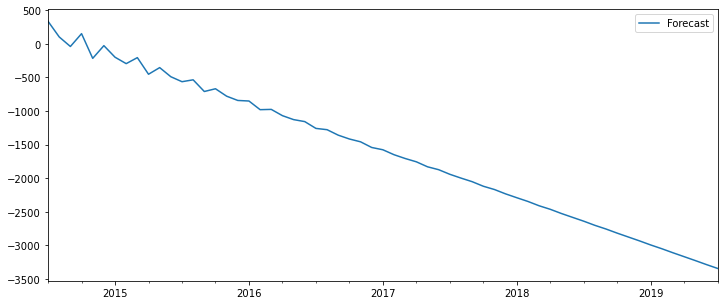

In [32]:
#Plot the graph for the future forecast data
pred.plot(figsize = (12, 5), legend=True)

### SALES FORECAST BY SALES CHANNEL 

#### Online

In [33]:
df2 = df.copy()

df2

,Revenue,SalesChannel,Region
OrderDate,,,
2011-05-31,2024.994,Reseller,Southeast
2011-05-31,6074.982,Reseller,Southeast
2011-05-31,2024.994,Reseller,Southeast
2011-05-31,2039.994,Reseller,Southeast
2011-05-31,2039.994,Reseller,Southeast
...,...,...,...
2014-06-30,21.980,Online,Canada
2014-06-30,8.990,Online,Canada
2014-06-30,21.980,Online,Canada


In [34]:
#Delete the Region Column
df2 = df2.drop(['Region'], axis=1)

In [35]:
df2

,Revenue,SalesChannel
OrderDate,,
2011-05-31,2024.994,Reseller
2011-05-31,6074.982,Reseller
2011-05-31,2024.994,Reseller
2011-05-31,2039.994,Reseller
2011-05-31,2039.994,Reseller
...,...,...
2014-06-30,21.980,Online
2014-06-30,8.990,Online
2014-06-30,21.980,Online


In [36]:
#ilter sales channel by online customers
df2['Online'] = df2['SalesChannel'].apply(lambda x: x == 'Online')

df2

,Revenue,SalesChannel,Online
OrderDate,,,
2011-05-31,2024.994,Reseller,False
2011-05-31,6074.982,Reseller,False
2011-05-31,2024.994,Reseller,False
2011-05-31,2039.994,Reseller,False
2011-05-31,2039.994,Reseller,False
...,...,...,...
2014-06-30,21.980,Online,True
2014-06-30,8.990,Online,True
2014-06-30,21.980,Online,True


In [37]:
#Grouping the data by monthly revenue and finding the mean for each month
df2 = df2.resample('MS').mean()

df2

,Revenue,Online
OrderDate,,
2011-05-01,1411.221056,0.014006
2011-06-01,3254.686701,1.000000
2011-07-01,2174.564385,0.165781
2011-08-01,2009.955727,0.120773
2011-09-01,3197.922585,1.000000
2011-10-01,2203.972573,0.083533
2011-11-01,3207.999223,1.000000
2011-12-01,2318.542982,0.332743
2012-01-01,2319.296981,0.112734


In [38]:
df2.head()

,Revenue,Online
OrderDate,,
2011-05-01,1411.221056,0.014006
2011-06-01,3254.686701,1.000000
2011-07-01,2174.564385,0.165781
2011-08-01,2009.955727,0.120773
2011-09-01,3197.922585,1.000000


### Visualize the data for Online Channels

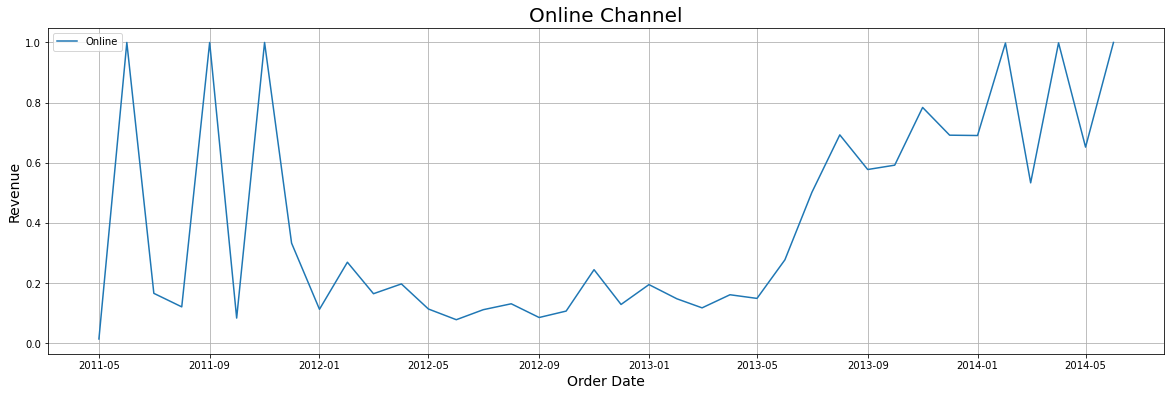

In [39]:
Online = df2['Online']

plt.figure(figsize=(20,6))
plt.title('Online Channel', fontsize=20)
plt.plot(Online, label='Online')
plt.legend(loc='best')
plt.xlabel('Order Date', fontsize=14)
plt.ylabel('Revenue', fontsize=14)
plt.grid(True)
plt.show()

### Check for Stationarity

In [40]:
#Testing for Stationarity using Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ad_test(df2):
    dftest = adfuller(df2, autolag = 'AIC')
    print('1. ADF: ', dftest[0])
    print('2. P-Values: ', dftest[1])
    print('3. Num of Lags: ', dftest[2])
    print('4. Num of Observations Used for ADF Regression and Critical Values Calculation: ', dftest[3])
    print('5. Critical Values :')
    for key, value in dftest[4].items():
        print('\t',key, ': ', value)

In [41]:
ad_test(df2['Online'])

1. ADF:  -1.3716828122661053
2. P-Values:  0.5957739513144013
3. Num of Lags:  1
4. Num of Observations Used for ADF Regression and Critical Values Calculation:  36
5. Critical Values :
	 1% :  -3.626651907578875
	 5% :  -2.9459512825788754
	 10% :  -2.6116707716049383


### Differencing

In [42]:
df2['First Difference'] = df2['Online'] - df2['Online'].shift(1)

In [43]:
df2

,Revenue,Online,First Difference
OrderDate,,,
2011-05-01,1411.221056,0.014006,NaN
2011-06-01,3254.686701,1.000000,0.985994
2011-07-01,2174.564385,0.165781,-0.834219
2011-08-01,2009.955727,0.120773,-0.045008
2011-09-01,3197.922585,1.000000,0.879227
2011-10-01,2203.972573,0.083533,-0.916467
2011-11-01,3207.999223,1.000000,0.916467
2011-12-01,2318.542982,0.332743,-0.667257
2012-01-01,2319.296981,0.112734,-0.220010


In [44]:
#Re-do the Dickey-Fuller Test
ad_test(df2['First Difference'].dropna())

1. ADF:  -15.033207568204896
2. P-Values:  9.834000391428296e-28
3. Num of Lags:  0
4. Num of Observations Used for ADF Regression and Critical Values Calculation:  36
5. Critical Values :
	 1% :  -3.626651907578875
	 5% :  -2.9459512825788754
	 10% :  -2.6116707716049383


<AxesSubplot:xlabel='OrderDate'>

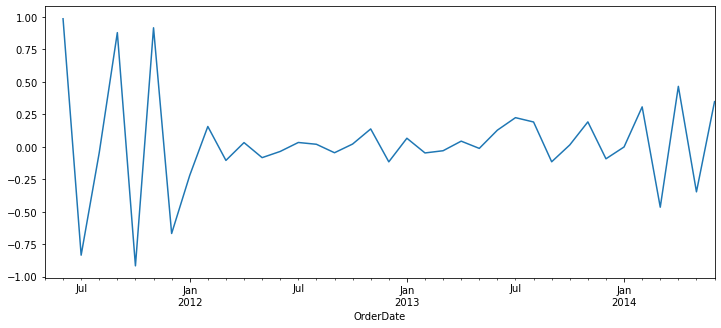

In [45]:
#Re-do the plot for the Revenue First Difference
df2['First Difference'].plot()

In [46]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(df2['Online'], trace=True,
                          suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.896, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.219, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15.523, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17.987, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.391, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10.741, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.992, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10.953, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.920, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4.629, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3.416, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5.701, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1.376, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9.490, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3.547, Time=0.05 sec
 ARIMA

In [47]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(2, 1, 1)   Log Likelihood                   3.312
Date:                Wed, 03 Feb 2021   AIC                              1.376
Time:                        11:16:58   BIC                              7.819
Sample:                             0   HQIC                             3.647
                                 - 38                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5177      0.115    -13.251      0.000      -1.742      -1.293
ar.L2         -0.8509      0.077    -11.061      0.000      -1.002      -0.700
ma.L1          0.5825      0.244      2.391      0.017       0.105       1.060
sigma2         0.0460      0.011      4.245      0.000       0.025       0.067
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.58   Prob(JB):                         0.61
Heteroskedasticity (H):               0.51   Skew:                            -0.30
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Training the Model

#### Split into Training and Test Data

In [48]:
from statsmodels.tsa.arima_model import ARIMA

print (df2.shape)
train = df2.iloc[:-10]
test = df2.iloc[-10:]
print(train.shape, test.shape)

(38, 3)
(28, 3) (10, 3)


In [49]:
model2 = ARIMA(train['Online'], order=(2,1,1))
model2=model2.fit()
model2.summary()

C:\Users\MMT\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\MMT\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA an

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Online   No. Observations:                   27
Model:                 ARIMA(2, 1, 1)   Log Likelihood                   0.049
Method:                       css-mle   S.D. of innovations              0.232
Date:                Wed, 03 Feb 2021   AIC                              9.901
Time:                        11:17:25   BIC                             16.380
Sample:                    06-01-2011   HQIC                            11.828
                         - 08-01-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0025      0.022      0.113      0.910      -0.041       0.046
ar.L1.D.Online    -1.5030      0.175     -8.611      0.000      -1.845      -1.161
ar.L2.D.Online    -0.8504      0.106     -8.039      0.000      -1.058      -0.643
ma.L1.D.Online     0.6399      0.277      2.311      0.021       0.097       1.183
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8837           -0.6285j            1.0844           -0.4016
AR.2           -0.8837           +0.6285j            1.0844            0.4016
MA.1           -1.5628           +0.0000j            1.5628            0.5000
-----------------------------------------------------------------------------
"""

In [50]:
start = len(train)
end=len(train)+len(test)-1
pred=model2.predict(start=start,end=end,typ='levels')
print(pred)

2013-09-01    0.491657
2013-10-01    0.639847
2013-11-01    0.596588
2013-12-01    0.544072
2014-01-01    0.668277
2014-02-01    0.534749
2014-03-01    0.638300
2014-04-01    0.604707
2014-05-01    0.575625
2014-06-01    0.656390
Freq: MS, dtype: float64


<AxesSubplot:xlabel='OrderDate'>

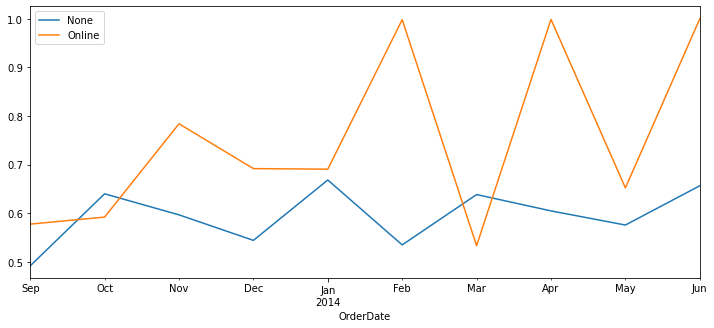

In [51]:
pred.plot(legend=True)
test['Online'].plot(legend=True)

In [52]:
test['Online'].mean()

0.7517660590633661

In [53]:
#To determine how good or bad the model is, use root mean squared
#The code below gives the root mean square
#Comapre with the mean above
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['Online']))
print(rmse)

0.23915045620446004


In [54]:
model2=ARIMA(df2['Online'],order=(0,1,0))
model2=model2.fit()
df2.tail()

C:\Users\MMT\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


,Revenue,Online,First Difference
OrderDate,,,
2014-02-01,312.479569,0.998131,0.307571
2014-03-01,727.166861,0.533199,-0.464932
2014-04-01,338.961509,0.998680,0.465480
2014-05-01,623.651075,0.651982,-0.346697
2014-06-01,23.007437,1.000000,0.348018


In [55]:
#Forecasting for the next 60 days (5 years)
pred=model2.predict(start=len(df2), end=len(df2)+60,typ='levels').rename('Forecast')
print(pred)

2014-07-01    1.026648
2014-08-01    1.053297
2014-09-01    1.079945
2014-10-01    1.106594
2014-11-01    1.133242
                ...   
2019-03-01    2.518964
2019-04-01    2.545613
2019-05-01    2.572261
2019-06-01    2.598910
2019-07-01    2.625558
Freq: MS, Name: Forecast, Length: 61, dtype: float64


<AxesSubplot:>

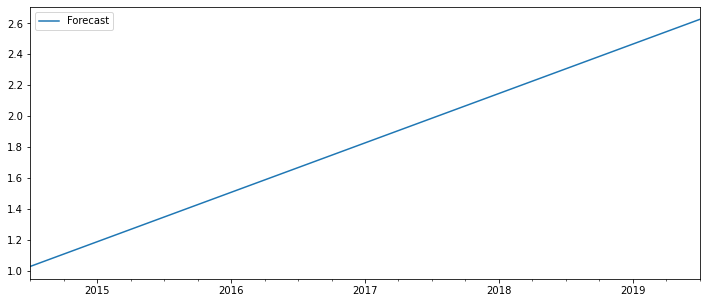

In [56]:
#Plot the graph for the future forecast data
pred.plot(figsize = (12, 5), legend=True)

### Reseller

In [57]:
df3 = df.copy()

df3

,Revenue,SalesChannel,Region
OrderDate,,,
2011-05-31,2024.994,Reseller,Southeast
2011-05-31,6074.982,Reseller,Southeast
2011-05-31,2024.994,Reseller,Southeast
2011-05-31,2039.994,Reseller,Southeast
2011-05-31,2039.994,Reseller,Southeast
...,...,...,...
2014-06-30,21.980,Online,Canada
2014-06-30,8.990,Online,Canada
2014-06-30,21.980,Online,Canada


In [58]:
#Delete the Region Column
df3 = df3.drop(['Region'], axis=1)

df3

,Revenue,SalesChannel
OrderDate,,
2011-05-31,2024.994,Reseller
2011-05-31,6074.982,Reseller
2011-05-31,2024.994,Reseller
2011-05-31,2039.994,Reseller
2011-05-31,2039.994,Reseller
...,...,...
2014-06-30,21.980,Online
2014-06-30,8.990,Online
2014-06-30,21.980,Online


In [59]:
#Filter sales channel by Resellers
df3['Reseller'] = df3['SalesChannel'].apply(lambda x: x == 'Reseller')

df3

,Revenue,SalesChannel,Reseller
OrderDate,,,
2011-05-31,2024.994,Reseller,True
2011-05-31,6074.982,Reseller,True
2011-05-31,2024.994,Reseller,True
2011-05-31,2039.994,Reseller,True
2011-05-31,2039.994,Reseller,True
...,...,...,...
2014-06-30,21.980,Online,False
2014-06-30,8.990,Online,False
2014-06-30,21.980,Online,False


In [60]:
df3 = df3.resample('MS').mean()

In [61]:
df3

,Revenue,Reseller
OrderDate,,
2011-05-01,1411.221056,0.985994
2011-06-01,3254.686701,0.000000
2011-07-01,2174.564385,0.834219
2011-08-01,2009.955727,0.879227
2011-09-01,3197.922585,0.000000
2011-10-01,2203.972573,0.916467
2011-11-01,3207.999223,0.000000
2011-12-01,2318.542982,0.667257
2012-01-01,2319.296981,0.887266


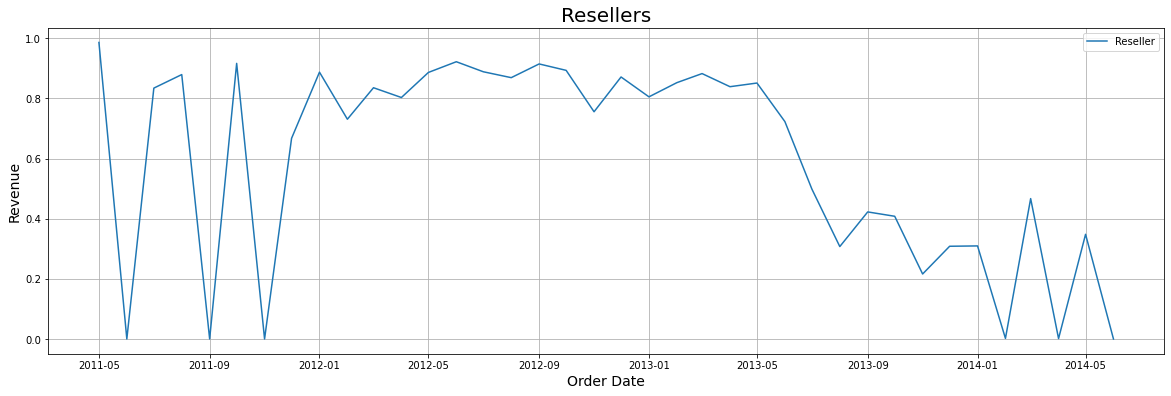

In [62]:
Reseller = df3['Reseller']

plt.figure(figsize=(20,6))
plt.title('Resellers', fontsize=20)
plt.plot(Reseller, label='Reseller')
plt.legend(loc='best')
plt.xlabel('Order Date', fontsize=14)
plt.ylabel('Revenue', fontsize=14)
plt.grid(True)
plt.show()

In [63]:
#Testing for Stationarity using Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ad_test(df3):
    dftest = adfuller(df3, autolag = 'AIC')
    print('1. ADF: ', dftest[0])
    print('2. P-Values: ', dftest[1])
    print('3. Num of Lags: ', dftest[2])
    print('4. Num of Observations Used for ADF Regression and Critical Values Calculation: ', dftest[3])
    print('5. Critical Values :')
    for key, value in dftest[4].items():
        print('\t',key, ': ', value)

In [64]:
ad_test(df3['Reseller'])

1. ADF:  -1.3716828122661058
2. P-Values:  0.595773951314401
3. Num of Lags:  1
4. Num of Observations Used for ADF Regression and Critical Values Calculation:  36
5. Critical Values :
	 1% :  -3.626651907578875
	 5% :  -2.9459512825788754
	 10% :  -2.6116707716049383


### Carry out differencing to make the data stationary

In [65]:
df3['Reseller First Difference'] = df3['Reseller'] - df3['Reseller'].shift(1)

In [66]:
df3

,Revenue,Reseller,Reseller First Difference
OrderDate,,,
2011-05-01,1411.221056,0.985994,NaN
2011-06-01,3254.686701,0.000000,-0.985994
2011-07-01,2174.564385,0.834219,0.834219
2011-08-01,2009.955727,0.879227,0.045008
2011-09-01,3197.922585,0.000000,-0.879227
2011-10-01,2203.972573,0.916467,0.916467
2011-11-01,3207.999223,0.000000,-0.916467
2011-12-01,2318.542982,0.667257,0.667257
2012-01-01,2319.296981,0.887266,0.220010


In [67]:
#Re-do the Dickey-Fuller Test
ad_test(df3['Reseller First Difference'].dropna())

1. ADF:  -15.033207568204897
2. P-Values:  9.834000391428013e-28
3. Num of Lags:  0
4. Num of Observations Used for ADF Regression and Critical Values Calculation:  36
5. Critical Values :
	 1% :  -3.626651907578875
	 5% :  -2.9459512825788754
	 10% :  -2.6116707716049383


<AxesSubplot:xlabel='OrderDate'>

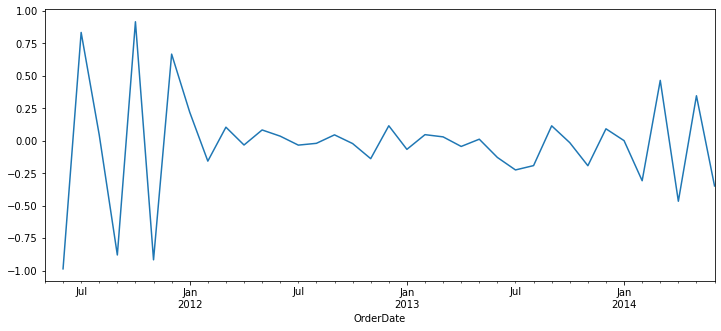

In [69]:
df3['Reseller First Difference'].plot()

In [70]:
from pmdarima import auto_arima

stepwise_fit_reseller = auto_arima(df3['Reseller'], trace=True,
                          suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.896, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.219, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15.523, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17.987, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.391, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10.741, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.992, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10.953, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.920, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4.629, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3.416, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5.701, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1.376, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9.490, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3.547, Time=0.08 sec
 ARIMA

In [71]:
stepwise_fit_reseller.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(2, 1, 1)   Log Likelihood                   3.312
Date:                Wed, 03 Feb 2021   AIC                              1.376
Time:                        11:21:11   BIC                              7.819
Sample:                             0   HQIC                             3.647
                                 - 38                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5177      0.115    -13.251      0.000      -1.742      -1.293
ar.L2         -0.8509      0.077    -11.061      0.000      -1.002      -0.700
ma.L1          0.5825      0.244      2.391      0.017       0.105       1.060
sigma2         0.0460      0.011      4.245      0.000       0.025       0.067
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.58   Prob(JB):                         0.61
Heteroskedasticity (H):               0.51   Skew:                             0.30
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Training the Model - Resellers

In [72]:
#Split the data into training and testing set

from statsmodels.tsa.arima_model import ARIMA

print (df3.shape)
train_reseller = df3.iloc[:-10]
test_reseller = df3.iloc[-10:]
print(train_reseller.shape, test_reseller.shape)

(38, 3)
(28, 3) (10, 3)


In [73]:
model_reseller = ARIMA(train_reseller['Reseller'], order=(2,1,1))
model_reseller=model_reseller.fit()
model_reseller.summary()

C:\Users\MMT\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\MMT\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA an

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.Reseller   No. Observations:                   27
Model:                 ARIMA(2, 1, 1)   Log Likelihood                   0.049
Method:                       css-mle   S.D. of innovations              0.232
Date:                Wed, 03 Feb 2021   AIC                              9.901
Time:                        11:21:26   BIC                             16.380
Sample:                    06-01-2011   HQIC                            11.828
                         - 08-01-2013                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0025      0.022     -0.113      0.910      -0.046       0.041
ar.L1.D.Reseller    -1.5030      0.175     -8.611      0.000      -1.845      -1.161
ar.L2.D.Reseller    -0.8504      0.106     -8.039      0.000      -1.058      -0.643
ma.L1.D.Reseller     0.6399      0.277      2.311      0.021       0.097       1.183
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8837           -0.6285j            1.0844           -0.4016
AR.2           -0.8837           +0.6285j            1.0844            0.4016
MA.1           -1.5628           +0.0000j            1.5628            0.5000
-----------------------------------------------------------------------------
"""

In [74]:
start = len(train_reseller)
end=len(train_reseller)+len(test_reseller)-1
pred_reseller=model_reseller.predict(start=start,end=end,typ='levels')
print(pred_reseller)

2013-09-01    0.508343
2013-10-01    0.360153
2013-11-01    0.403412
2013-12-01    0.455928
2014-01-01    0.331723
2014-02-01    0.465251
2014-03-01    0.361700
2014-04-01    0.395293
2014-05-01    0.424375
2014-06-01    0.343610
Freq: MS, dtype: float64


<AxesSubplot:xlabel='OrderDate'>

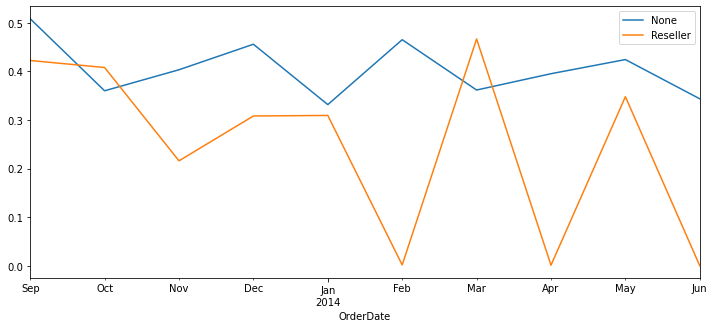

In [75]:
pred_reseller.plot(legend=True)
test_reseller['Reseller'].plot(legend=True)

In [76]:
test_reseller['Reseller'].mean()

0.24823394093663378

In [77]:
#To determine how good or bad the model is, use root mean squared
#The code below gives the root mean square
#Comapre with the mean above
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred_reseller,test_reseller['Reseller']))
print(rmse)

0.23915045447933428


In [80]:
model_reseller=ARIMA(df3['Reseller'],order=(2,1,1))
model_reseller=model_reseller.fit()
df3.tail()

C:\Users\MMT\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


,Revenue,Reseller,Reseller First Difference
OrderDate,,,
2014-02-01,312.479569,0.001869,-0.307571
2014-03-01,727.166861,0.466801,0.464932
2014-04-01,338.961509,0.001320,-0.465480
2014-05-01,623.651075,0.348018,0.346697
2014-06-01,23.007437,0.000000,-0.348018


In [83]:
##Forecasting for the next 60 days (5 years)
pred_reseller=model_reseller.predict(start=len(df2), end=len(df2)+60,typ='levels').rename('Reseller Forecast')
print(pred_reseller)

2014-07-01    0.051710
2014-08-01    0.233958
2014-09-01   -0.120102
2014-10-01    0.225176
2014-11-01   -0.030881
                ...   
2019-03-01   -0.489124
2019-04-01   -0.499714
2019-05-01   -0.507727
2019-06-01   -0.521544
2019-07-01   -0.528780
Freq: MS, Name: Reseller Forecast, Length: 61, dtype: float64


<AxesSubplot:>

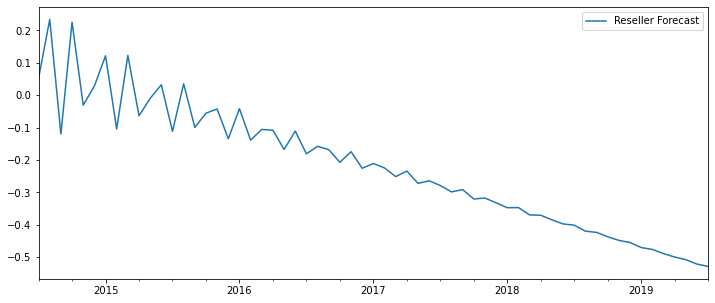

In [84]:
#Plot the graph for the future forecast data
pred_reseller.plot(figsize = (12, 5), legend=True)